In [ ]:
# Cell 1: Install required packages
%pip install pymongo python-dotenv pandas seaborn matplotlib ipython boto3 anthropic
%!pip install markdown

Configuration

In [2]:
# Cell 2: Configuration Setup
import os
from dotenv import load_dotenv
from data_extractor import MongoDBExtractor
from datetime import datetime, timedelta
import pandas as pd

# Load environment variables
load_dotenv()

# Initialize MongoDB extractor
extractor = MongoDBExtractor()
extractor.connect()

# 1. Selected users for analysis (subset of 3 from config.py)
test_users = [
    'ptr_dvd',      # Active Kohelet Forum member
    'SagiBarmak',   # Prominent voice
    'KoheletForum'  # Official account
]
print("Users to analyze:", test_users)

# 2. Define analysis periods
pre_war_end = '2023-10-07'    # Day before the war
post_war_start = '2024-12-30'  # War start date
days_back = 90                 # Days to analyze for each period

# Create timestamp objects for reference
pre_war_end_date = datetime.strptime(pre_war_end, '%Y-%m-%d')
post_war_start_date = datetime.strptime(post_war_start, '%Y-%m-%d')

# 3. Additional parameters
MODEL_NAME = "anthropic.claude-3-haiku-20240307-v1:0"  # Current model
os.environ['MODEL_NAME'] = MODEL_NAME

# Directory structure for data organization
DATA_DIRS = {
    'raw': os.path.join('data', 'raw'),
    'pre_war': os.path.join('data', 'raw', 'pre_war'),
    'post_war': os.path.join('data', 'raw', 'post_war'),
    'analysis': os.path.join('data', 'analysis'),
    'cleaned': os.path.join('data', 'cleaned')
}

# Create necessary directories
for dir_path in DATA_DIRS.values():
    os.makedirs(dir_path, exist_ok=True)

print(f"\nAnalysis Configuration:")
print(f"Pre-war period: {pre_war_end_date - timedelta(days=days_back)} to {pre_war_end_date}")
print(f"Post-war period: {post_war_start_date - timedelta(days=days_back)} to {post_war_start_date}")
print(f"Days analyzed per period: {days_back}")
print(f"Model: {MODEL_NAME}")

Successfully connected to MongoDB
Users to analyze: ['ptr_dvd', 'SagiBarmak', 'KoheletForum']

Analysis Configuration:
Pre-war period: 2023-07-09 00:00:00 to 2023-10-07 00:00:00
Post-war period: 2024-10-01 00:00:00 to 2024-12-30 00:00:00
Days analyzed per period: 90
Model: anthropic.claude-3-haiku-20240307-v1:0


Fetch data

In [3]:
# Cell 3: Fetch and Clean Data
from tweet_cleaner import TweetCleaner
print("\nFetching and cleaning data for both periods...")

# Initialize tweet cleaner with all parameters enabled
cleaner = TweetCleaner(min_words=7, remove_mentions=True, remove_urls=True)

# Process pre-war data
print("\nProcessing pre-war period data...")
pre_war_df = extractor.extract_tweets_by_date_range(
    reference_date=pre_war_end,
    days_back=days_back,
    usernames=test_users,
    period_label='pre_war'
)
pre_war_cleaned = cleaner.clean_tweets(pre_war_df, period_label='pre_war')
print(f"Pre-war tweets after cleaning: {len(pre_war_cleaned)}")

# Process post-war data
print("\nProcessing post-war period data...")
post_war_df = extractor.extract_tweets_by_date_range(
    reference_date=post_war_start,
    days_back=days_back,
    usernames=test_users,
    period_label='post_war'
)
post_war_cleaned = cleaner.clean_tweets(post_war_df, period_label='post_war')
print(f"Post-war tweets after cleaning: {len(post_war_cleaned)}")


Fetching and cleaning data for both periods...

Processing pre-war period data...
Successfully connected to MongoDB
Fetching tweets from 2023-07-09 00:00:00 to 2023-10-07 23:59:59
Using timestamps from 1688850000 to 1696712399
Fetched 190 tweets for ptr_dvd
Fetched 161 tweets for SagiBarmak
Fetched 79 tweets for KoheletForum
Saved raw data to: data\raw\pre_war\tweets_pre_war_20250113_102748.csv

Cleaning tweets...
- Removing URLs
- Removing @mentions
- Filtering tweets with less than 7 words

Tweet counts before and after cleaning:
----------------------------------------------------------------------
KoheletForum         - original:   79, cleaned:   70 (removed:    9,   11.4%)
SagiBarmak           - original:  161, cleaned:  118 (removed:   43,   26.7%)
ptr_dvd              - original:  190, cleaned:  142 (removed:   48,   25.3%)
----------------------------------------------------------------------
Total tweets - original: 430, after cleaning: 330
Total removed: 100 (23.3%)

Saved c

Enhanced users analysis

In [4]:
# Cell 4: Analyze Individual Users
from analyzer import TweetAnalyzer
from analyzer_enhanced import EnhancedTweetAnalyzer
print("\nAnalyzing individual users for both periods...")

# Initialize analyzers
basic_analyzer = TweetAnalyzer(batch_size=50, max_retries=3)
enhanced_analyzer = EnhancedTweetAnalyzer(batch_size=50, max_retries=3)

# Process pre-war period
print("\nAnalyzing pre-war period...")

# Step 1: Basic Analysis
pre_war_analyses = []
for username in pre_war_cleaned['author_username'].unique():
    user_tweets = pre_war_cleaned[pre_war_cleaned['author_username'] == username].to_dict('records')
    analysis = basic_analyzer.analyze_user_tweets(username, user_tweets)
    pre_war_analyses.append(analysis)
pre_war_merged = basic_analyzer.merge_user_analyses(pd.concat(pre_war_analyses), period_label='pre_war')
print(f"Completed basic pre-war analysis for {len(pre_war_merged)} users")

# Step 2: Enhanced Analysis (passing both merged analysis and cleaned tweets)
pre_war_enhanced = enhanced_analyzer.merge_user_analyses_enhanced(
    df=pre_war_merged,
    tweets_df=pre_war_cleaned,
    period_label='pre_war'
)
print(f"Completed enhanced pre-war analysis")

# Process post-war period
print("\nAnalyzing post-war period...")

# Step 1: Basic Analysis
post_war_analyses = []
for username in post_war_cleaned['author_username'].unique():
    user_tweets = post_war_cleaned[post_war_cleaned['author_username'] == username].to_dict('records')
    analysis = basic_analyzer.analyze_user_tweets(username, user_tweets)
    post_war_analyses.append(analysis)
post_war_merged = basic_analyzer.merge_user_analyses(pd.concat(post_war_analyses), period_label='post_war')
print(f"Completed basic post-war analysis for {len(post_war_merged)} users")

# Step 2: Enhanced Analysis (passing both merged analysis and cleaned tweets)
post_war_enhanced = enhanced_analyzer.merge_user_analyses_enhanced(
    df=post_war_merged,
    tweets_df=post_war_cleaned,
    period_label='post_war'
)
print(f"Completed enhanced post-war analysis")


Analyzing individual users for both periods...

Analyzing pre-war period...

Analyzing tweets for @ptr_dvd
Total tweets: 142
Number of batches: 3
✓ Batch 1/3 completed
✓ Batch 2/3 completed
✓ Batch 3/3 completed

Completed analysis for @ptr_dvd: 3 batches processed

Analyzing tweets for @SagiBarmak
Total tweets: 118
Number of batches: 3
✓ Batch 1/3 completed
✓ Batch 2/3 completed
✓ Batch 3/3 completed

Completed analysis for @SagiBarmak: 3 batches processed

Analyzing tweets for @KoheletForum
Total tweets: 70
Number of batches: 2
✓ Batch 1/2 completed
✓ Batch 2/2 completed

Completed analysis for @KoheletForum: 2 batches processed

Merging analyses for @KoheletForum
Total batches to analyze: 2

Merging analyses for @SagiBarmak
Total batches to analyze: 3

Merging analyses for @ptr_dvd
Total batches to analyze: 3

Saved merged analysis to: data\analysis\pre_war\merged_analysis_pre_war_20250113_103010.csv
Completed basic pre-war analysis for 3 users

Adding enhanced metrics for pre_war 

Users analysis report

In [ ]:
# Cell 5: Generate Individual Users Report
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, clear_output
from report_generator import UsersReport

# Find the most recent enhanced analysis files
pre_war_pattern = os.path.join('data', 'analysis', 'pre_war', 'merged_analysis_pre_war_enhanced_*.csv')
post_war_pattern = os.path.join('data', 'analysis', 'post_war', 'merged_analysis_post_war_enhanced_*.csv')

pre_war_files = glob.glob(pre_war_pattern)
post_war_files = glob.glob(post_war_pattern)

if not pre_war_files or not post_war_files:
    raise FileNotFoundError("Enhanced analysis files not found. Please run the enhanced analysis first.")

# Get the most recent files
pre_war_file = max(pre_war_files, key=os.path.getctime)
post_war_file = max(post_war_files, key=os.path.getctime)

# Read the enhanced analysis results
pre_war_enhanced = pd.read_csv(pre_war_file)
post_war_enhanced = pd.read_csv(post_war_file)

# Define users to analyze
test_users = [
    'ptr_dvd',      # Active Kohelet Forum member
    'SagiBarmak',   # Prominent voice
    'KoheletForum'  # Official account
]

# Initialize report generator
report_generator = UsersReport()

# Generate reports for each user
for username in test_users:
    # Get user data
    pre_war_user = pre_war_enhanced[pre_war_enhanced['username'] == username]
    post_war_user = post_war_enhanced[post_war_enhanced['username'] == username]
    
    if pre_war_user.empty or post_war_user.empty:
        print(f"No data found for user {username}")
        continue
    
    # Generate report and figures
    report, figures = report_generator.generate_report(
        pre_war_data=pre_war_user,
        post_war_data=post_war_user,
        username=username
    )
    
    # Display report content
    display(Markdown(report))
    
    # Display figures
    for fig in figures:
        display(fig)
        plt.close(fig)
    
    # Add separator between users (except for last user)
    if username != test_users[-1]:
        display(Markdown("---"))

print("\nReport generation completed successfully!")

Group analysis and reporting

# Group Analysis Report

**Analysis Periods:**
- Pre-war: July 9, 2023 - October 7, 2023 (90 days before the war)
- Post-war: October 1, 2024 - December 30, 2024 (90 days at end of 2024)

## Overall Statistics

### Tweet Volume Analysis

- Total Pre-war Tweets: 330
- Total Post-war Tweets: 1,072
- Overall Change: +742


Top Volume Changes:
- <span style='color: #3498DB'>@SagiBarmak</span>: +449 tweets (+380.5%)
- <span style='color: #3498DB'>@ptr_dvd</span>: +268 tweets (+188.7%)
- <span style='color: #3498DB'>@KoheletForum</span>: +25 tweets (+35.7%)


### Most Toxic Tweets

Pre-war Period:
- <span style='color: #3498DB'>@SagiBarmak</span> (toxicity: 80.0):
  ```
  אחרי שניגבו את הרצפה עם טל רוסו, עכשיו מגיע תורו של בני גנץ לקבל טיפול דומה.
  ```
- <span style='color: #3498DB'>@SagiBarmak</span> (toxicity: 80.0):
  ```
  בן אדם, אתה פה? זה ליטרלי מה שאומרים לך לא שגיא ברמק ושמעון נטף אלא היועמשים למיניהם.
  ```
- <span style='color: #3498DB'>@ptr_dvd</span> (toxicity: 75.0):
  ```
  מוסרית מדובר במעשה מתועב ושפל. אך יש קשיים תאורטיים לא מבוטלים ביישום הפללה של שקרים שקודמים ליחסי מין.
  ```

Post-war Period:
- <span style='color: #3498DB'>@SagiBarmak</span> (toxicity: 80.0):
  ```
  האסלאם הרדיקלי הוא הדבר הקרוב ביותר שיש לרוע בצורתו המובהקת ביותר.
  ```
- <span style='color: #3498DB'>@SagiBarmak</span> (toxicity: 80.0):
  ```
  לפני שמחסלים את מחבלי חיזבאללה קוראים ב-'השילוח'.
  ```
- <span style='color: #3498DB'>@ptr_dvd</span> (toxicity: 80.0):
  ```
  יהודים חמושים זו ציונות. מדיניות ממשלתית חשובה.
  ```


### Metrics Analysis


**Judicial-Security Balance**
(0: security focus, 100: judicial reform focus)

**Group Average Change: -17.4**

**Top Changes:**
- <span style='color: #3498DB'>@KoheletForum</span> <span style='color: #E74C3C'>-25.0 points</span> │ Pre: 62.5 → Post: 37.5
- <span style='color: #3498DB'>@SagiBarmak</span> <span style='color: #E74C3C'>-18.8 points</span> │ Pre: 66.7 → Post: 47.9
- <span style='color: #3498DB'>@ptr_dvd</span> <span style='color: #E74C3C'>-8.3 points</span> │ Pre: 58.3 → Post: 50.0



**Rights-Security Balance**
(0: security focus, 100: rights focus)

**Group Average Change: -13.8**

**Top Changes:**
- <span style='color: #3498DB'>@SagiBarmak</span> <span style='color: #E74C3C'>-20.9 points</span> │ Pre: 66.7 → Post: 45.8
- <span style='color: #3498DB'>@KoheletForum</span> <span style='color: #E74C3C'>-20.0 points</span> │ Pre: 57.5 → Post: 37.5
- <span style='color: #3498DB'>@ptr_dvd</span> <span style='color: #E74C3C'>-0.5 points</span> │ Pre: 53.3 → Post: 52.8



**Emergency Powers Position**
(0: opposing emergency powers and wartime measures, 100: supporting expanded government authority during crisis)

**Group Average Change: +11.8**

**Top Changes:**
- <span style='color: #3498DB'>@KoheletForum</span> <span style='color: #2ECC71'>+18.3 points</span> │ Pre: 45.0 → Post: 63.3
- <span style='color: #3498DB'>@SagiBarmak</span> <span style='color: #2ECC71'>+16.5 points</span> │ Pre: 33.3 → Post: 49.9
- <span style='color: #3498DB'>@ptr_dvd</span> <span style='color: #2ECC71'>+0.5 points</span> │ Pre: 46.7 → Post: 47.2



**Domestic-International Focus**
(0: international focus, 100: domestic focus)

**Group Average Change: -13.6**

**Top Changes:**
- <span style='color: #3498DB'>@KoheletForum</span> <span style='color: #E74C3C'>-32.5 points</span> │ Pre: 82.5 → Post: 50.0
- <span style='color: #3498DB'>@SagiBarmak</span> <span style='color: #E74C3C'>-6.7 points</span> │ Pre: 83.8 → Post: 77.1
- <span style='color: #3498DB'>@ptr_dvd</span> <span style='color: #E74C3C'>-1.7 points</span> │ Pre: 76.7 → Post: 75.0



### Entity Changes

**Top New Attacked Entities (Post-war):**
• <span style='color: #3498DB'>the political left</span>
• <span style='color: #3498DB'>OCHA-oPT</span>
• <span style='color: #3498DB'>UNRWA</span>
• <span style='color: #3498DB'>Francesca Albanese</span>
• <span style='color: #3498DB'>kamala harris</span>
• <span style='color: #3498DB'>the palestinian national movement</span>
• <span style='color: #3498DB'>Ilana Dayan</span>
• <span style='color: #3498DB'>Yair Lapid</span>

**No Longer Attacked (Pre-war only):**
• <span style='color: #9B59B6'>Pnina Tamano-Shata</span>
• <span style='color: #9B59B6'>Supreme Court</span>
• <span style='color: #9B59B6'>Attorney General</span>
• <span style='color: #9B59B6'>Gali Baharav-Miara</span>
• <span style='color: #9B59B6'>Meretz</span>
• <span style='color: #9B59B6'>Avichai Mandelblit</span>
• <span style='color: #9B59B6'>Aviad Glickman</span>
• <span style='color: #9B59B6'>Yuli Edelstein</span>

**Top New Protected Entities (Post-war):**
• <span style='color: #3498DB'>Hezbollah</span>
• <span style='color: #3498DB'>Donald Trump</span>
• <span style='color: #3498DB'>itamar ben-gvir</span>
• <span style='color: #3498DB'>bezalel smotrich</span>
• <span style='color: #3498DB'>Ayelet Shaked</span>
• <span style='color: #3498DB'>Naftali Bennett</span>
• <span style='color: #3498DB'>Michael Oren</span>
• <span style='color: #3498DB'>benjamin netanyahu</span>

**No Longer Protected (Pre-war only):**
• <span style='color: #9B59B6'>Antonin Scalia</span>
• <span style='color: #9B59B6'>Knesset</span>
• <span style='color: #9B59B6'>Prime Minister Netanyahu</span>
• <span style='color: #9B59B6'>Yuli Edelstein</span>
• <span style='color: #9B59B6'>Jeremy Waldron</span>
• <span style='color: #9B59B6'>Prime Minister</span>


### Narrative Evolution

Pre-war Top Narratives:
- Defending parliamentary democracy and legislative supremacy
- Promoting free market economics and privatization
- Advocating for reduced government regulation

Post-war Top Narratives:
- Promoting Israel's Jewish national identity
- Advocating for reduced government regulation
- Criticizing the political left

Key Changes:
- Increased focus on promoting Israel's Jewish identity and national character, shifting away from broader economic and judicial reform narratives
- Continued advocacy for reduced government regulation, but with less emphasis on privatization and free market economics
- Emergence of a new narrative criticizing the political left and left-wing media forces
- Reduced focus on defending parliamentary democracy and legislative supremacy, as well as criticizing judicial activism and overreach



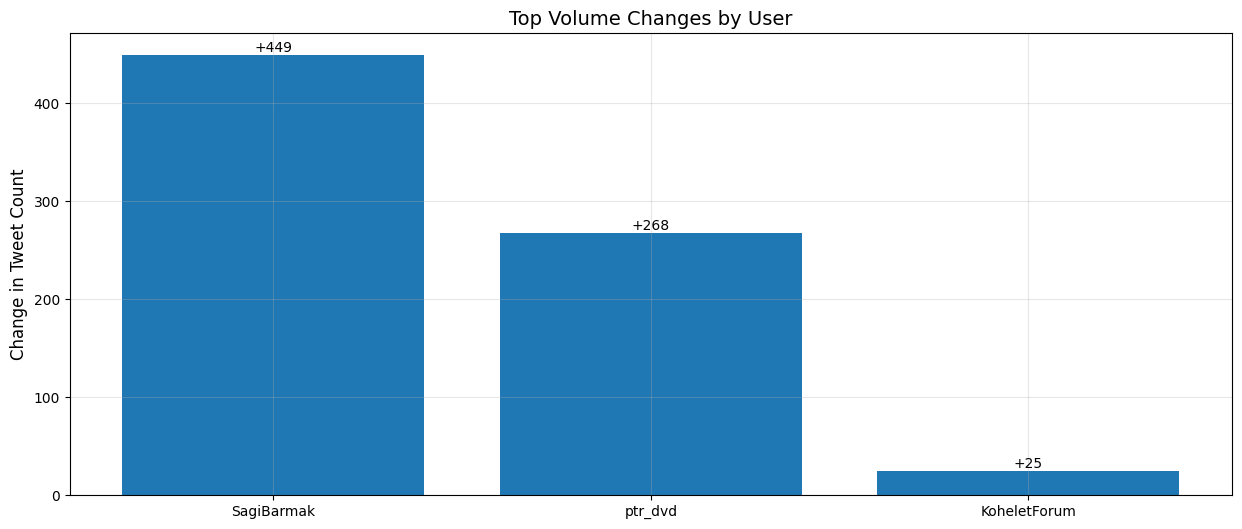

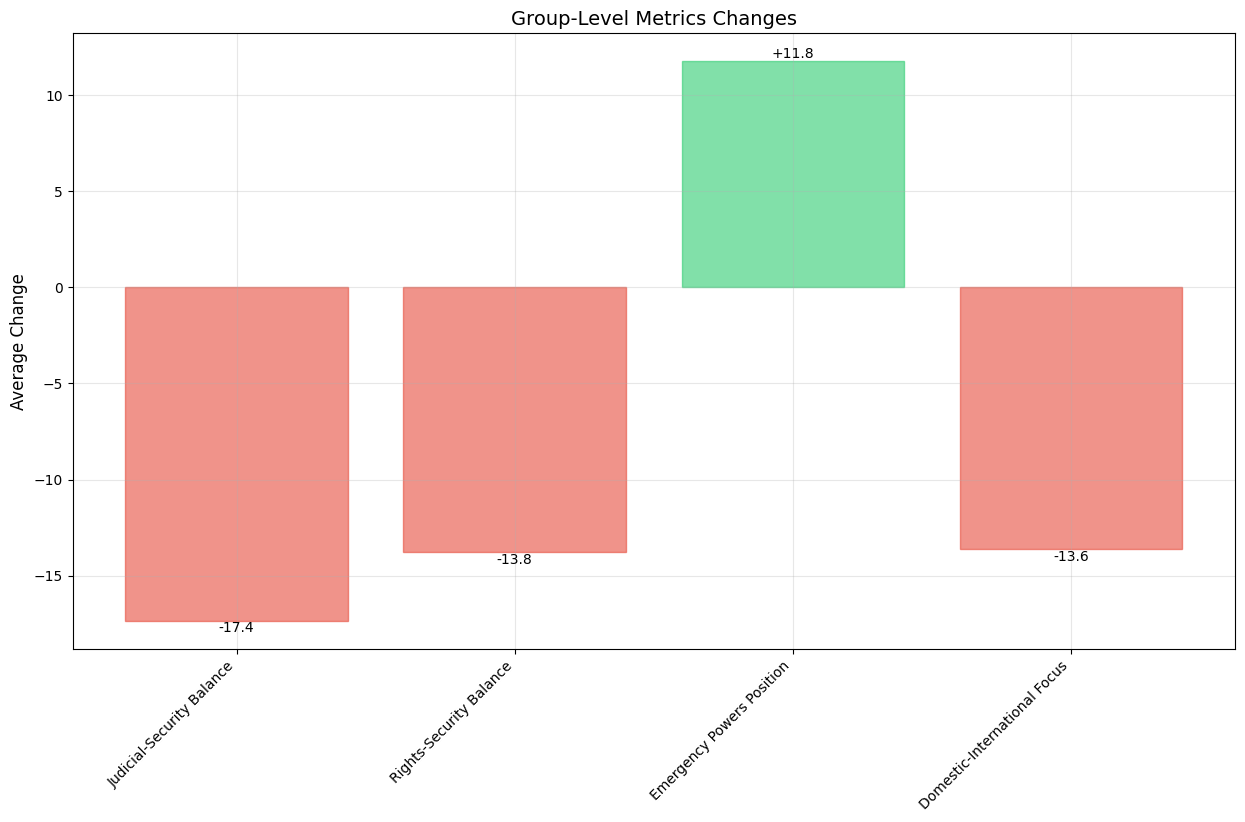

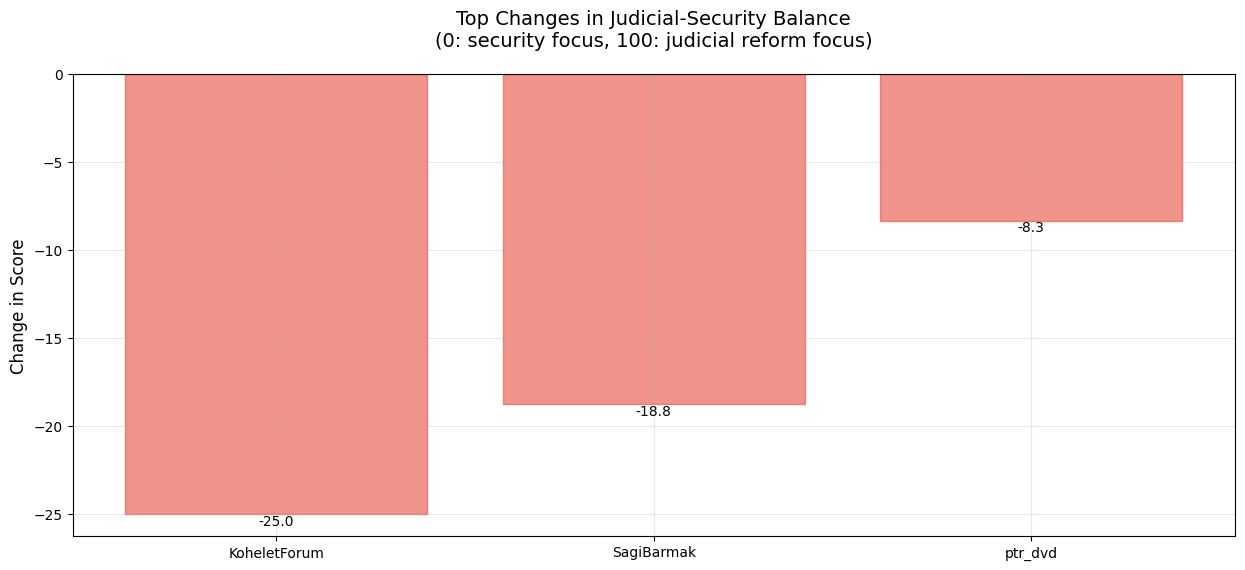

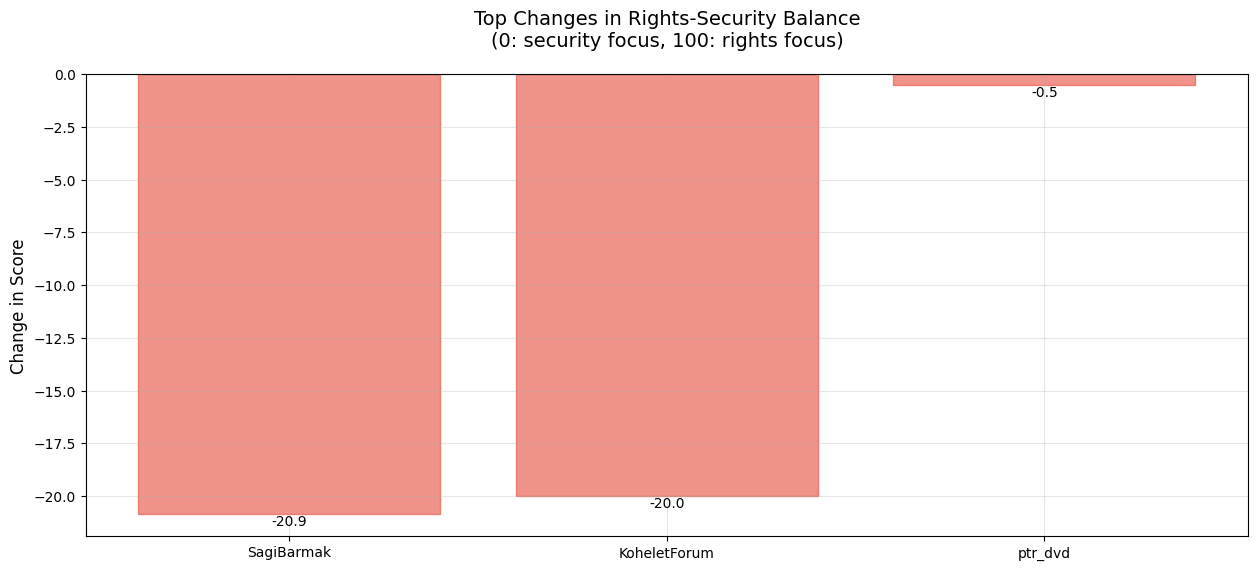

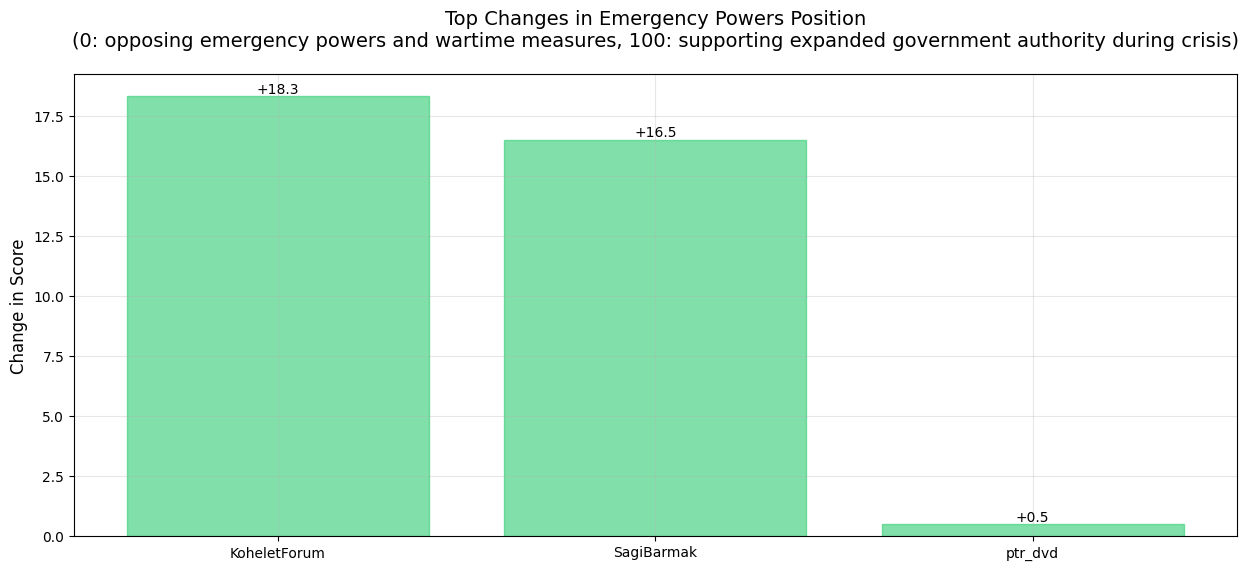

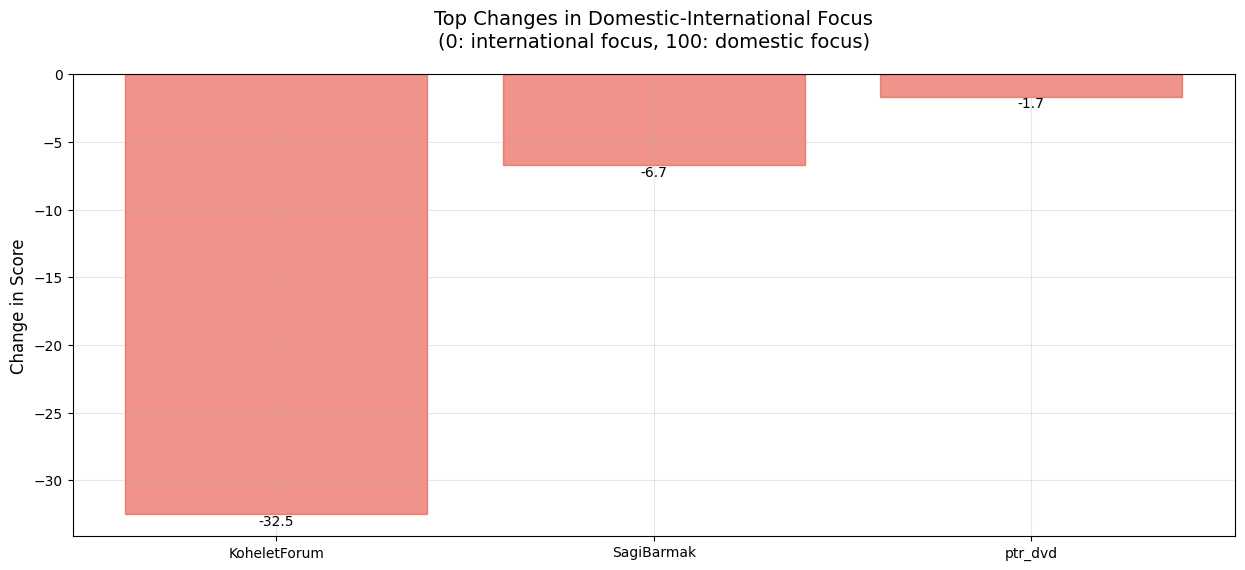

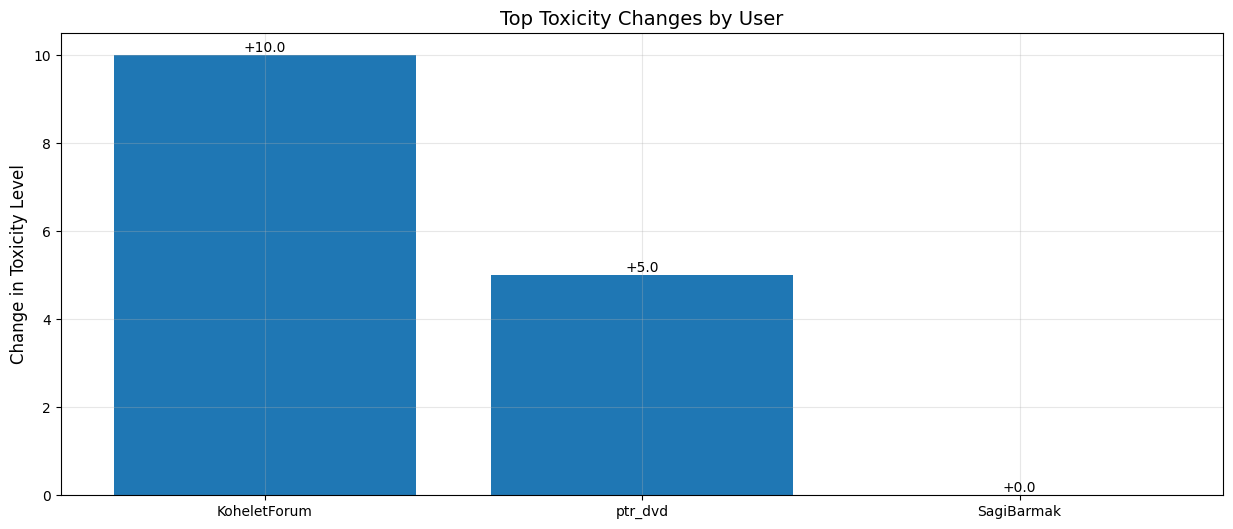

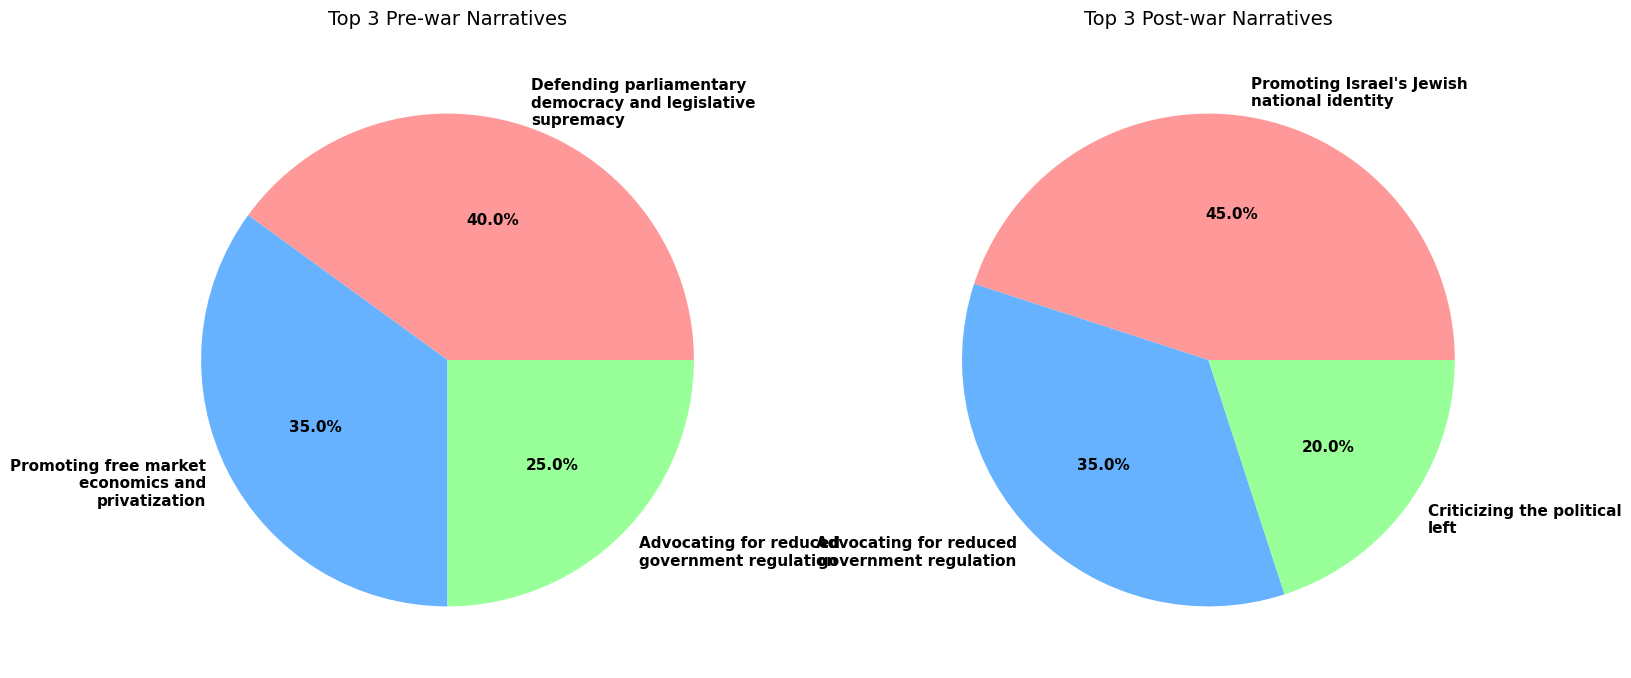

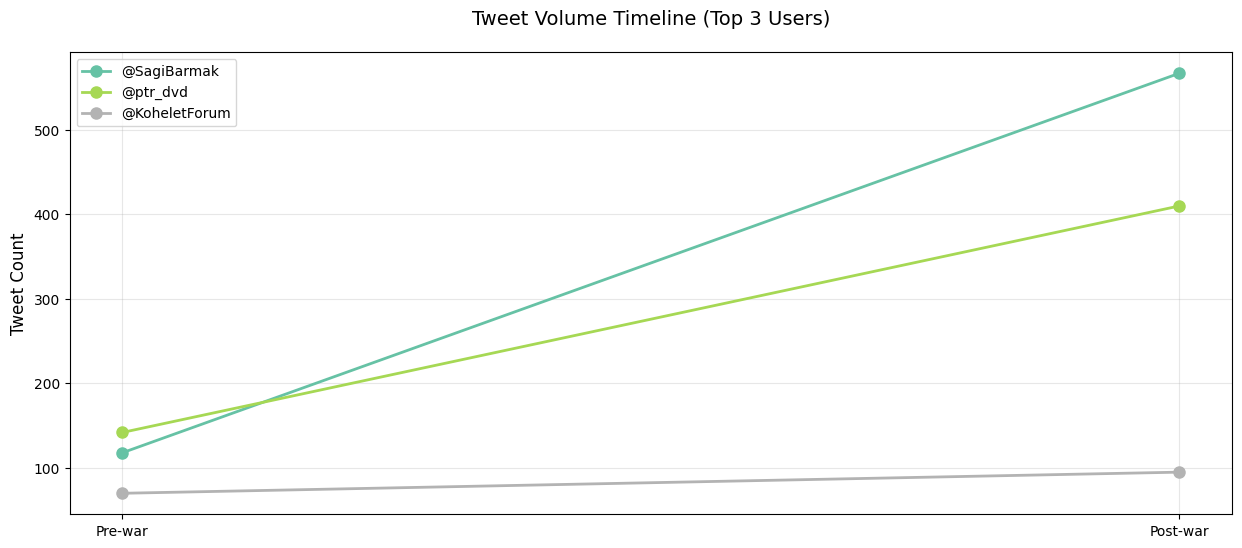

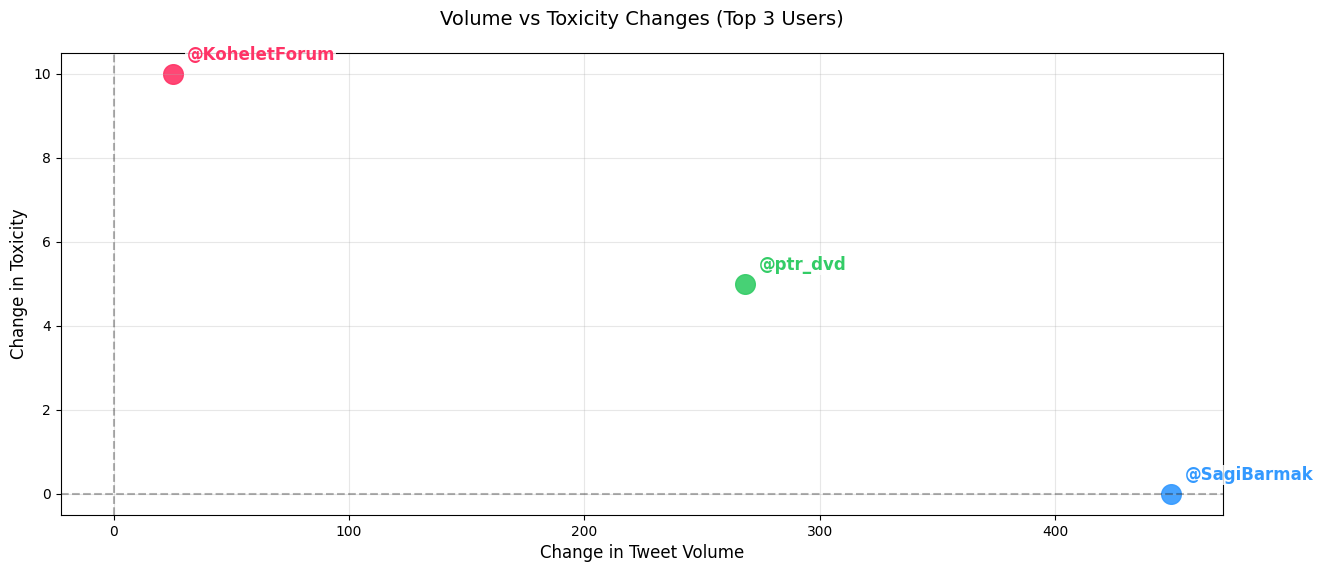

In [1]:
# Cell 6: Group Analysis
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from analyzer_group import GroupAnalyzer

# Find most recent enhanced analysis files
pre_war_pattern = 'data/analysis/pre_war/merged_analysis_pre_war_enhanced_*.csv'
post_war_pattern = 'data/analysis/post_war/merged_analysis_post_war_enhanced_*.csv'

# Get the most recent files
pre_war_files = glob.glob(pre_war_pattern)
post_war_files = glob.glob(post_war_pattern)

if pre_war_files and post_war_files:
    # Get most recent files
    pre_war_file = max(pre_war_files)
    post_war_file = max(post_war_files)
    
    # Read the data
    pre_war_data = pd.read_csv(pre_war_file)
    post_war_data = pd.read_csv(post_war_file)
    
    # Initialize group analyzer
    group_analyzer = GroupAnalyzer()
    
    # Generate group analysis
    results = group_analyzer.analyze_group(pre_war_data, post_war_data)
    
    # Generate and display report
    report_text, figures = group_analyzer.generate_report(results)
    display(Markdown(report_text))
    
    # Display figures
    for fig in figures:
        display(fig)
        plt.close(fig)  # Close figure to free memory
else:
    print("Error: Could not find analysis files")

Generate group report

In [11]:
# Export the reports to HTML
from html_exporter import HTMLExporter

# Initialize the exporter
exporter = HTMLExporter()

# Export group report using the already generated report_text and figures
output_path = exporter.export_report(report_text, figures)
print(f"Group report exported to: {output_path}")

Group report exported to: analysis_report_20250113_155201.html
